In [1]:
# -------
# IMPORT LIBRAIRIES
# -------
import numpy as np
import pandas as pd
import plotly.express as px
from python_module.pricing_model import SABRModel
from python_module.tools import maximize_with_bounds

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# -------
# INPUTS
# -------

# Pricing parameters
F     = 5000
alpha = 0.15
beta  = 1.0
rho   = -0.5
nu    = 1.5
r     = 0
bd = 5

# Scenario parameters
scenario_min = -0.1
scenario_max = 0.1
scenario_step = 0.02

target_gamma = 10_000_000

In [3]:
# Scenario parameters
num = int((scenario_max-scenario_min)/0.01 + 1)
slide_to_compute = list(np.round(np.linspace(start=scenario_min, stop=scenario_max, num=num), 2))

In [32]:
strike_list = []
T = bd / 250
for delta in [-0.01, -0.1, 0.5, 0.1, 0.01]:
    option_type = 'call' if delta > 0 else 'put'
    K = SABRModel.solve_delta_strike(F=F, T=T, alpha=alpha, beta=beta, rho=rho, nu=nu, r=r, option_type=option_type, target_delta=delta)
    K = int(K)
    strike_list.append(K)
strike_list = sorted(strike_list)

In [34]:
# Option portfolio
market_data_list = list()
for K in strike_list:
    T = bd / 250
    option_type = 'call' if K >= F else 'put'
    market_pricing_results = SABRModel.compute_option(F, K, T, alpha, beta, rho, nu, r, option_type, slide_list=slide_to_compute)
    market_data_list.append({
        'symbol': f"{bd}T_{K}K_{option_type}",
        'option_type': option_type, 
        'time_to_maturity': bd, 
        'F':F, 'r': r, 'K': K, 'T': T, 'K/F': (K/F) - 1 ,**market_pricing_results})

market_data_df = pd.DataFrame(market_data_list)
market_data_df = market_data_df.set_index('symbol')
market_data_df = market_data_df.drop(0, axis=1)
market_data_df[0] = market_data_df['theta']

In [70]:
market_data_df

,option_type,time_to_maturity,F,r,K,T,K/F,IV,price,delta,gamma,vega,theta,vanna,volga,-0.10,-0.09,-0.08,-0.07,-0.06,-0.05,-0.04,-0.03,-0.02,-0.01,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0
symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5T_4757K_put,put,5,5000,0,4757,0.02,-0.05,0.17,0.87,-0.02,0.00,0.34,-0.58,-0.56,822.10,247.94,200.89,155.84,114.20,77.71,48.04,26.21,12.05,4.25,0.86,0.34,1.13,2.06,3.03,4.01,4.98,5.96,6.93,7.91,8.89,-0.58
5T_4857K_put,put,5,5000,0,4857,0.02,-0.03,0.16,5.55,-0.10,0.00,1.25,-2.03,-1.37,"1,231.75",301.16,256.49,212.23,168.89,127.35,89.09,56.02,30.06,12.42,2.93,1.40,5.08,9.71,14.66,19.69,24.74,29.79,34.83,39.88,44.93,-2.03
5T_5000K_call,call,5,5000,0,5000,0.02,0.00,0.15,42.39,0.50,0.00,2.82,-4.24,0.03,-0.21,209.73,184.53,159.34,134.19,109.16,84.44,60.47,38.17,19.12,5.61,3.67,16.09,34.98,57.55,81.71,106.36,131.13,155.92,180.70,205.49,-4.24
5T_5130K_call,call,5,5000,0,5130,0.02,0.03,0.14,4.83,0.10,0.00,1.26,-1.79,1.62,"1,454.41",46.24,41.13,36.02,30.92,25.82,20.72,15.66,10.70,6.02,2.09,1.75,10.22,28.17,56.52,93.41,135.42,179.57,224.33,269.21,314.10,-1.79
5T_5208K_call,call,5,5000,0,5208,0.02,0.04,0.14,0.68,0.02,0.00,0.33,-0.45,0.70,"1,030.94",8.85,7.90,6.94,5.99,5.04,4.09,3.14,2.20,1.29,0.49,0.43,3.16,10.79,26.79,53.77,91.32,136.00,183.91,232.77,281.80,-0.45


In [36]:
A = market_data_df.loc[:,  [-0.05, -0.01, 0.0, 0.01, 0.05]]
B = (pd.Series([-0.05, -0.01, 0.0, 0.01, 0.05]).pow(2) * 50 * F).to_list()
#B = [10_000] * A.shape[0]

In [60]:
B = [625.0000000000001, 25.0, -10000, 25.0, 625.0000000000001]

In [62]:
A

,-0.05,-0.01,0,0.01,0.05
symbol,,,,,
5T_4757K_put,48.04,0.86,-0.58,0.34,4.01
5T_4857K_put,89.09,2.93,-2.03,1.40,19.69
5T_5000K_call,84.44,5.61,-4.24,3.67,81.71
5T_5130K_call,20.72,2.09,-1.79,1.75,93.41
5T_5208K_call,4.09,0.49,-0.45,0.43,53.77


In [64]:
X = np.linalg.solve(A, B)
weights = pd.Series(X, index=market_data_df.index)
print(weights)

symbol
5T_4757K_put        -135.21
5T_4857K_put    -163,171.61
5T_5000K_call   -330,984.04
5T_5130K_call   -125,911.25
5T_5208K_call       -294.36
dtype: float64


In [66]:
market_data_df['vega']*weights

symbol
5T_4757K_put         -45.35
5T_4857K_put    -203,893.82
5T_5000K_call   -933,636.03
5T_5130K_call   -158,671.53
5T_5208K_call        -96.69
dtype: float64

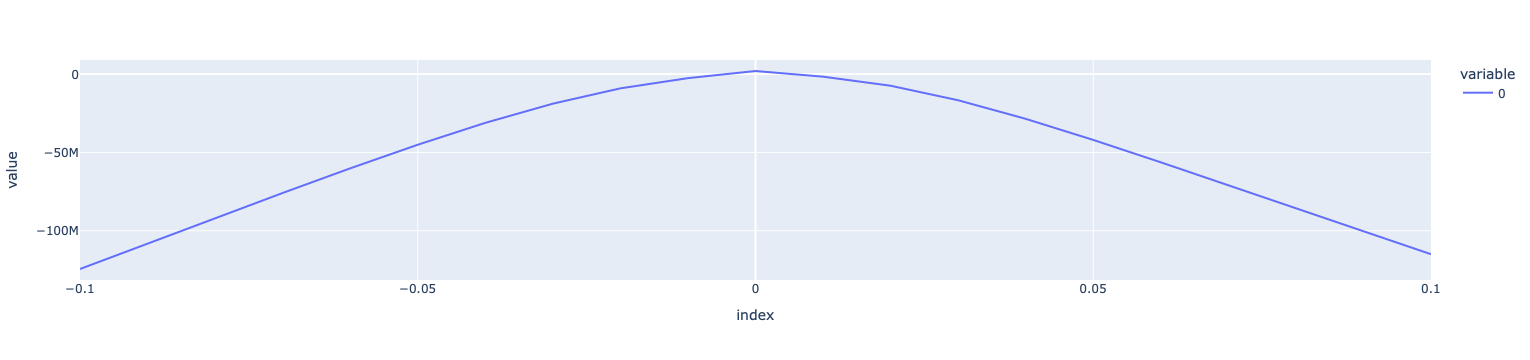

In [68]:
px.line(market_data_df.loc[:, slide_to_compute].multiply(weights, axis=0).sum(axis=0).sort_index())

In [46]:
market_data_df.loc[:, ['vega', 'theta']].multiply(weights, axis=0).sum(axis=0)

vega     324,717.18
theta   -490,664.65
dtype: float64